In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
pip install split_folders

Note: you may need to restart the kernel to use updated packages.


In [32]:
import tensorflow.compat.v2 as tf 
from keras import backend as k 
from keras.applications.mobilenet import MobileNet
from keras.applications import imagenet_utils
import keras.applications
from keras.engine import training
from keras.layers import VersionAwareLayers
from keras.utils import data_utils
from keras.utils import layer_utils
from tensorflow.keras.utils import Sequence
from tensorflow.python.util.tf_export import keras_export
from keras.layers import Dense,GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.layers import Flatten
from keras.callbacks import CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import seaborn as sns 
# from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet152,  preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
# from tensorflow.keras.applications.inception_v3  import preprocess_input, InceptionV3
import numpy as np 
import matplotlib.pyplot as plt 
import splitfolders

# from google.colab.patches import cv2_imshow

In [9]:
from splitfolders.split import ratio
import os 
input_path = "/kaggle/input/cell-images-for-detecting-malaria/cell_images"
splitfolders.ratio(input_path,output = "/kaggle/working/train_test_val",seed = 42,ratio = (0.8,0.1,0.1),group_prefix=None)


Copying files: 27560 files [02:44, 167.56 files/s]


In [16]:
# os.chdir ('/kaggle/working/train_test_val/test/cell_images')

!rm -d  /kaggle/working/train_test_val/val/cell_images
print(os.listdir( "/kaggle/working/train_test_val/train"))

['Uninfected', 'Parasitized']


In [17]:
train_path = "/kaggle/working/train_test_val/train"
val_path = "/kaggle/working/train_test_val/val"
test_path = "/kaggle/working/train_test_val/test"
pre_process_input = tf.keras.applications.resnet.preprocess_input
generator = ImageDataGenerator(preprocessing_function=pre_process_input)
size = 224
train_data = generator.flow_from_directory(train_path,
 target_size=(size,size),batch_size= 32,
 class_mode='categorical' )

val_data = generator.flow_from_directory(val_path,
 target_size=(size,size),batch_size= 32,
 class_mode='categorical' )


test_data = generator.flow_from_directory(test_path,
 target_size=(size,size),batch_size= 32,
 class_mode='categorical',shuffle=False )

print(train_data.classes)
print(val_data.classes)

Found 22046 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


In [33]:

image_size = [size,size]
model = ResNet152(input_shape= image_size + [3],weights='imagenet',include_top=False)

for layer in model.layers:
  layer.trainable = False
# for layer in range(170,175):
#   model.layers[layer].trainable = True

x = Flatten()(model.output)
# x = Dense(64,activation='softmax')(x)
# x= Dropout(0.5)(x)
# x = Dense(32,activation='softmax')(x)
# x= Dropout(0.5)(x)
x = Dense(2,activation='softmax')(x)
classifier = Model(inputs = model.input,outputs = x)
classifier.compile(loss='categorical_crossentropy',optimizer = 'adam',metrics=['accuracy'])

234698864/234698864 [==============================] - 1s 0us/step


In [34]:
his = classifier.fit(train_data,validation_data=val_data,epochs=11)

Epoch 1/11
689/689 [==============================] - 218s 303ms/step - loss: 1.8109 - accuracy: 0.9057 - val_loss: 1.5596 - val_accuracy: 0.9122
Epoch 2/11
689/689 [==============================] - 205s 298ms/step - loss: 1.1472 - accuracy: 0.9409 - val_loss: 1.4592 - val_accuracy: 0.9485
Epoch 3/11
689/689 [==============================] - 205s 297ms/step - loss: 1.0820 - accuracy: 0.9512 - val_loss: 1.7288 - val_accuracy: 0.9405
Epoch 4/11
689/689 [==============================] - 205s 297ms/step - loss: 0.7788 - accuracy: 0.9634 - val_loss: 1.4842 - val_accuracy: 0.9507
Epoch 5/11
689/689 [==============================] - 204s 297ms/step - loss: 0.5093 - accuracy: 0.9721 - val_loss: 1.7304 - val_accuracy: 0.9514
Epoch 6/11
689/689 [==============================] - 205s 297ms/step - loss: 0.5022 - accuracy: 0.9762 - val_loss: 2.0424 - val_accuracy: 0.9481
Epoch 7/11
689/689 [==============================] - 204s 297ms/step - loss: 0.4909 - accuracy: 0.9763 - val_loss: 2.8974 -

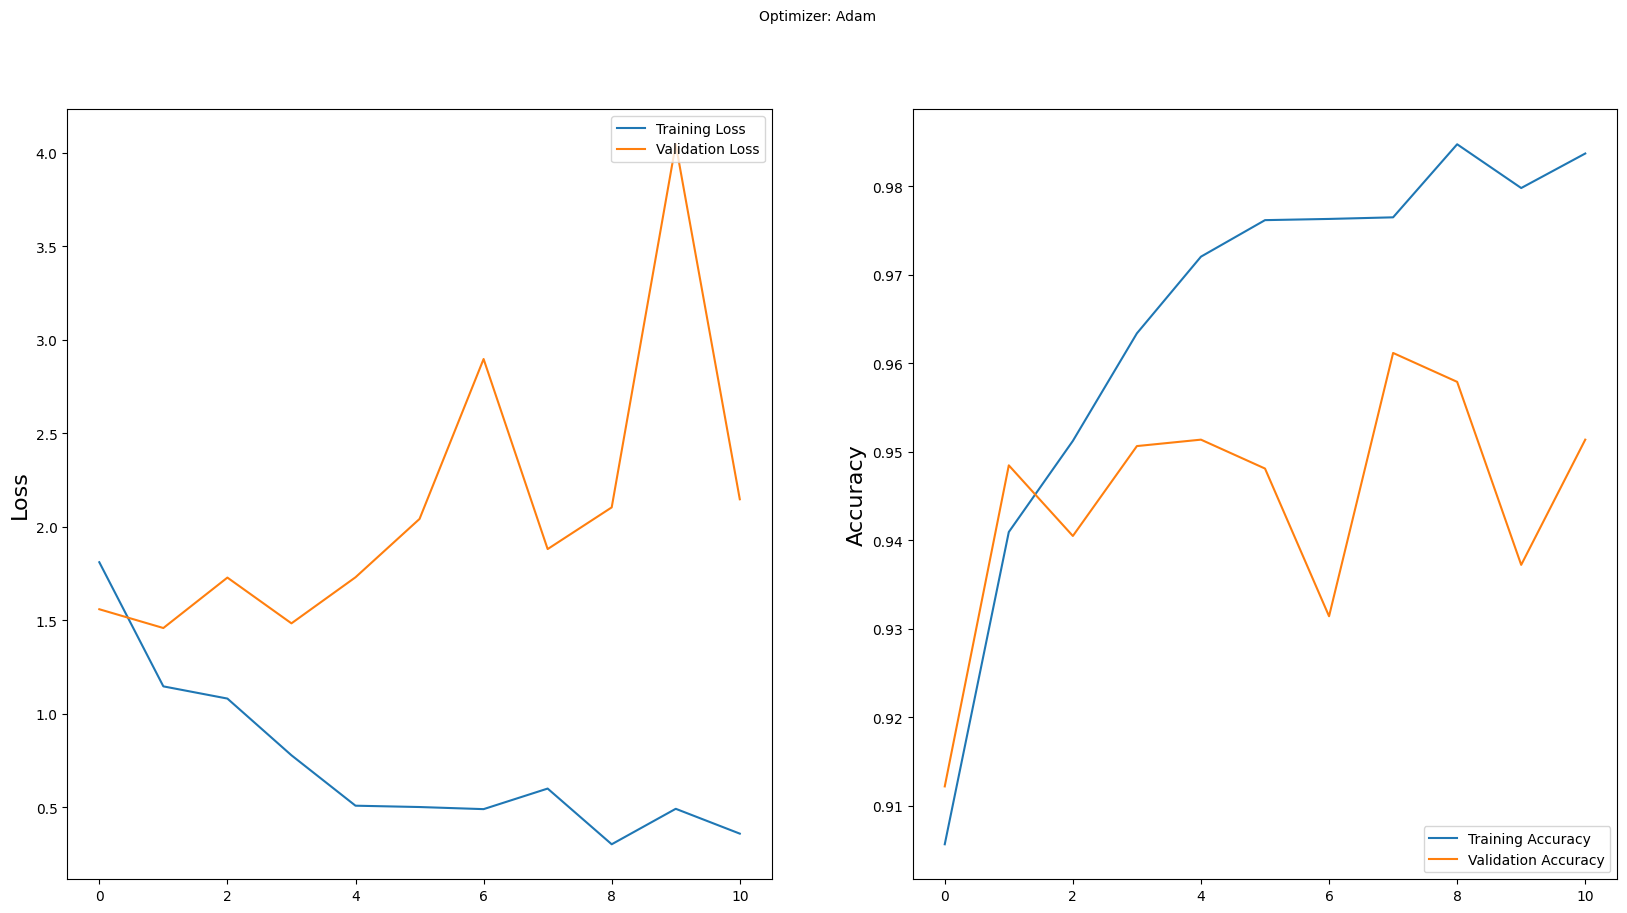

In [35]:
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
plt.suptitle("Optimizer: Adam", fontsize = 10)
plt.ylabel("Loss",fontsize = 16)

plt.plot(his.history['loss'],label = "Training Loss")
plt.plot(his.history['val_loss'],label = "Validation Loss")
plt.legend(loc = 'upper right')

plt.subplot(1,2,2)

plt.ylabel("Accuracy",fontsize = 16)

plt.plot(his.history['accuracy'],label = "Training Accuracy")
plt.plot(his.history['val_accuracy'],label = "Validation Accuracy")
plt.legend(loc = 'lower right')


In [36]:
from sklearn.metrics import accuracy_score

y_true = test_data.classes
print(y_true)
pred = classifier.predict(test_data)
pred = tf.argmax(pred,axis = 1)
print(accuracy_score(pred,y_true))

[0 0 0 ... 1 1 1]
87/87 [==============================] - 25s 262ms/step
0.9361393323657474


[[1301   77]
 [  99 1279]]
93.61


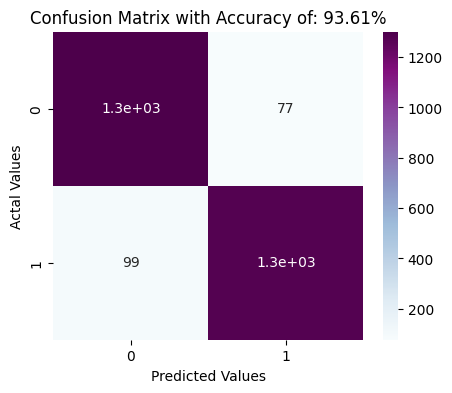

In [37]:
from sklearn.metrics import confusion_matrix
import pandas as pd
cm = confusion_matrix(y_true, pred)

print(cm)
acc = str(accuracy_score(y_true, pred)*100)
acc = acc[0:5]
print(acc)
cm_df = pd.DataFrame(cm,index = 
[0,1], columns = 
[0,1])
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True,cmap=plt.cm.BuPu)
plt.title('Confusion Matrix with Accuracy of: {0}%'.format(acc))
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [38]:
model.save('/kaggle/working/resnet152.h5')